# AutoGenU for Jupyter: Fault-Tolerant Control of a Quadrotor

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

## Quadrotor Model   
#### Variables
$\xi$: position in the inertial frame $\{ e_1^\textrm{i}, e_2^\textrm{i}, e_3^\textrm{i} \}$  
$v$: velocity in the intertial frame $\{ e_1^\textrm{i}, e_2^\textrm{i}, e_3^\textrm{i} \}$  
$q$: unit quaternion (in the body frame) representing the rotation of the inertial frame $\{ e_1^\textrm{i}, e_2^\textrm{i}, e_3^\textrm{i} \}$ to the body frame $\{ e_1^\textrm{b}, e_2^\textrm{b}, e_3^\textrm{b} \}$:   
$e_j^\textrm{b} = q \otimes e_j^\textrm{i} \otimes q^* (j=1,2,3)$ holds, where $\otimes$ denotes the product of quaternions, and $q^*$ denotes the conjugate quaternion of $q$.   
$\omega$: angular velocity in the body frame $\{ e_1^\textrm{b}, e_2^\textrm{b}, e_3^\textrm{b} \}$   
$u$: thrust vector   
#### Parameters   
$m$: mass, $J$: moment of intertia, $d_3$: coefficient of aerodynamic drag in the yaw axis, $\ell$ distance between the center of mass and each rotor,   
$k$: a coefficient representing the relationship between the thrust and reaction torque in each rotor,   
$c_1$: thrust reduction factor of rotor No. 1 ($0 \leq c_1 \leq 1$) (1: normal, 0: completely failed) 
#### State Equation
$$\begin{array}{l}
    \dot{\xi} = v \\
    \dot{v} = -g e_3^\textrm{i} + \frac{1}{m} e_3^\textrm{b}(q) s^{\top} u \\   % E_3^\textrm{b}(q) u \\
    \dot{q} = \frac{1}{2} \Omega(\omega) q   \quad \textrm{Note that $q$ is in the inertial frame while $\omega$ is in the body frame. This is correct with $\Omega(\omega)$ defined appropriately.} \\
    \dot{\omega} = - J^{-1} \omega^{\times} J \omega - J^{-1} D \omega + J^{-1} T u 
\end{array} $$  
where
$$\begin{array}{l}
e_3^\textrm{b}(q) &=& \left[ 2(q_0 q_2 + q_1 q_3) \quad 2(q_2 q_3 - q_0 q_1) \quad q_0^2 - q_1^2 - q_2^2 + q_3^2 \right]^{\top} \in \mathbb{R}^3, \\
    s &=& \left[ c_1 \; 1 \; 1 \; 1 \right]^{\top} \in \mathbb{R}^4 \\
    \omega^{\times} &=& \begin{bmatrix}
            0    &  -\omega_3  &   \omega_2 \\
        \omega_3 &       0     &  -\omega_1 \\
       -\omega_2 &   \omega_1  &      0     \\
      \end{bmatrix}  \in \mathbb{R}^{3 \times 3}, \\
    \Omega &=& \begin{bmatrix}
           0   &  -\omega^{\top} \\
        \omega &  -\omega^{\times}
      \end{bmatrix}   \in \mathbb{R}^{4 \times 4}, \\
    D &=& {\rm diag}[0,0,d_3] \in \mathbb{R}^{3 \times 3} \\
    T &=& \begin{bmatrix}
           0  &  \ell &  0   & -\ell \\
        - c_1 \ell &   0   & \ell &   0  \\
          c_1 k  &  -k   &  k   &  -k  
      \end{bmatrix} \in \mathbb{R}^{3 \times 4},
\end{array}$$
#### Representations by Array x
$$\xi = [x[0],x[1],x[2]], v = [x[3],x[4],x[5]], q = [x[6],x[7],x[8],x[9]], \omega = [x[10],x[11],x[12]]$$
$$e_3^\textrm{b}(q) = [ 2*(x[6]*x[8] + x[7]*x[9]) \quad 2*(x[8]*x[9] - x[6]*x[7]) \quad x[6]**2 - x[7]**2 - x[8]**2 + x[9]**2 ]$$

---

# Generate C++ code for optimal control problem (OCP)

## Import module

In [1]:
import autogenu

## Set dimensions and define `AutoGenU`
- `nx`: Dimension of the state vector $x$   
- `nu`: Dimension of the control input vector $u$  
- `ocp_name`: Name of the optimal control problem (OCP). Used as the name of the directory containing the generated C++ source files.

In [2]:
nx = 13
nu = 4
ocp_name = 'QuadrotorFTC'
ag = autogenu.AutoGenU(ocp_name, nx, nu)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem
- `t`: Time parameter $t$  
- `x`: The state vector $x$  
- `u`: The control input vector $u$  

In [3]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()

## Define variables used in the state equation, constraints, and cost function
- Define a scalar variable whose name is "var" as  
`var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
`vec = ag.define_array_var('vec', dim_vec)`

In [4]:
# Variables used in the state function
m, g, J1, J2, J3, d3, l, k, c1 = ag.define_scalar_vars('m', 'g', 'J1', 'J2', 'J3', 'd3', 'l', 'k', 'c1')
# Variables used in the cost function
s = ag.define_array_var('s', nx)
s_terminal = ag.define_array_var('s_terminal', nx)
x_ref = ag.define_array_var('x_ref', nx)
r = ag.define_array_var('r', nu)
u_ref = ag.define_array_var('u_ref', nu)

## Define the state equation, constraints, the stage cost, and the terminal cost
- `f`: The state equation $ f(t, x, u)$  
- `C`: The equality constraisnts $C(t, x, u) = 0 $  
- `h`: The inequality constraisnts $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method  
- `L`: The stage cost $L(t, x, u)$  
- `phi`: The terminal cost $\phi (t, x)$  

Note: array indices start with 0

In [5]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, sinh, cosh, tanh, diff, sqrt

In [6]:
# Define the state equation
f = [𝑥[3],
     𝑥[4],
     𝑥[5],
     2*(x[6]*x[8] + x[7]*x[9]) * (c1*u[0] + u[1] + u[2] + u[3])/m,
     2*(x[8]*x[9] - x[6]*x[7]) * (c1*u[0] + u[1] + u[2] + u[3])/m,
     -g + (x[6]**2 - x[7]**2 - x[8]**2 + x[9]**2) * (c1*u[0] + u[1] + u[2] + u[3])/m,
     (           - x[7]*𝑥[10] - x[8]*𝑥[11] - x[9]*𝑥[12])/2,
     (x[6]*𝑥[10]              + x[8]*x[12] - x[9]*x[11])/2,
     (x[6]*x[11] - x[7]*x[12]              + x[9]*x[10])/2,
     (x[6]*x[12] + x[7]*x[11] - x[8]*x[10]             )/2,
     (J2*x[11]*x[12] - J3*x[11]*x[12] + l*u[1] - l*u[3])/J1,
     (-J1*x[10]*x[12] + J3*x[10]*x[12] - l*c1*u[0] + l*u[2])/J2,
     (J1*x[10]*x[11] - J2*x[10]*x[11] - d3*x[12] + k*c1*u[0] - k*u[1] + k*u[2] - k*u[3])/J3
    ]

# Define the constraints
C = []

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
h = []

# Define the stage cost
L = sum(s[i]*(x[i] - x_ref[i])**2 for i in range(nx))/2 + sum(r[i] * (u[i] - u_ref[i])**2 for i in range(nu))/2

# Define the terminal cost
phi = sum(s_terminal[i]*(x[i] - x_ref[i])**2 for i in range(nx))/2 

In [7]:
# Set functions
ag.set_functions(f, C, h, L, phi)

## Define the control input bound constraints
The box constraints on the control input $u_{\rm min} \leq u \leq u_{\rm max}$ are treated in a special manner.
Specifically, it is transformed into $$u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0$$.  
Further, $u_{\rm dummy}$ and associated Lagrange multiplier are eliminated in Newton-type iteration efficiently in the multiple-shooting solver.  
Set such box constraints by specifying
- `uindex`: index of the constrained control input element
- `umin`: Minimum value (lower bound) of the control input element
- `umax`: Maximum value (upper bound) of the control input element
- `dummy_weight`: Weight parameter of the dummy (slack) variable

In [8]:
for uindex in range(nu):
    ag.add_control_input_bounds(uindex=uindex, umin=0.0065, umax=0.3266, dummy_weight=100.0)  

## Set Parameters
Set values for all parameters you defined.
- Set `value` for a scalar variable whose name is "var" as  
`ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
`ag.define_array_var('vec', [var_1, var_2, ..., var_n])`

In [9]:
ag.set_scalar_vars(['m',0.063], ['g',9.81], ['J1',5.83e-5], ['J2',7.17e-5], ['J3',1.00e-4], ['d3',1.0e-3], ['l',0.0624], ['k',0.0731],['c1',0.0])  
ag.set_array_var('s', [5,5,50, 1,1,1, 0,1,1,1, 0.1,0.1,0.1])  # Zero weight for q_0
ag.set_array_var('s_terminal', [5,5,50, 1,1,1, 0,1,1,1, 0.1,0.1,0.1])
ag.set_array_var('x_ref', [0,0,0, 0,0,0, 1,0,0,0, 0,0,0]) 
ag.set_array_var('r', [1,1,1,1])
u_ref_eq = m*g/(c1+3)
ag.set_array_var('u_ref', [u_ref_eq,u_ref_eq,u_ref_eq,u_ref_eq])  

## Generate C++ codes of the definition of the optimal control problem
Generate `ocp.hpp` that defines the optimal control problem (OCP).  
- `simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.  
- `common_subexpression_elimination`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `ocp.hpp` is generated. Default is `False`. 

In [10]:
simplification = False
common_subexpression_elimination = True

ag.generate_ocp_definition(simplification, common_subexpression_elimination)

'ocp.hpp', the definition of the OCP, is generated at C:\Users\ohtsu\OneDrive - Kyoto Univ\ToCheck\BenchmarkBook\Test\QuadrotorFTC_Benchmark\generated\QuadrotorFTC


---  
# Generate C++ codes of NMPC solver and numerical simulation  

## Set NLP type  
Set which NLP formulation you use. (hint: `MultipleShooting` works better for typical nonlinear problems.)
- `MultipleShooting` (recommended) : The multiple shooting based C/GMRES method with condensing of the state and the Lagragne multipliers with respect to the state equation.
- `SingleShooting` : The single shooting method, i.e., the original C/GMRES method.

In [11]:
nlp_type = autogenu.NLPType.MultipleShooting
#nlp_type = autogenu.NLPType.SingleShooting
ag.set_nlp_type(nlp_type)

## Set horizon length 

- `Tf`, `alpha`: Parameters for the length of the horizon. If $\alpha > 0$, time-varying horizon length $T(t) = T_f (1 - e^{-\alpha t})$ is used. Otherwise, $T(t)$ is fixed by $T_f$. 

In [12]:
Tf = 0.4
alpha = 1.0

ag.set_horizon_params(Tf, alpha)

## Set parameters for the C/GMRES method

- `sampling_time`: Sampling period.
- `N`: The number of the discretization grids of the horzion.  
- `finite_difference_epsilon`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.   
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.  
- `kmax`: The maximam number of the iteration of the GMRES.

In [13]:
sampling_time = 1.0e-3
N = 100
finite_difference_epsilon = 1e-8
zeta = 1/sampling_time
kmax = 10

ag.set_solver_params(sampling_time, N, finite_difference_epsilon, zeta, kmax)

## Set parameters for the initialization of the solution  
- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.   
- `tolerance`: The residual tolerance of the solution of the OCP for the initialization of the solution of NMPC. The Newton iteration terminates when the optimality error is less than this velue.  
- `max_iterations`: The maxmum number of Newton iteration for the initialization of the solution of NMPC.  

In [14]:
solution_initial_guess = [0.1,0.11,0.09,0.12]  # Non-uniform values often work well. 
tolerance = 1e-6
max_iterations = 100 

ag.set_initialization_params(solution_initial_guess, tolerance, max_iterations)

## Set parameters for numerical simulation
- `initial_time`: Initial time of the numerical simulation.  
- `initial_state`: Initial state vector of the system.  
- `simulation_length`: Simulation length.  

In [15]:
initial_time = 0
initial_state = [-1,-1,-1, 0,0,0, 1,0,0,0, 0,0,0]  
#import math
#initial_state = [-1,-1,-1, 0,0,0, math.cos(math.pi/8),0,math.sin(math.pi/8),0, 0,1,0]  # Initial Pitch Angle theta: Initial Quaternion [cos(theta/2),0,sin(theta/2),0]
simulation_length = 10

ag.set_simulation_params(initial_time, initial_state, simulation_length) 

## Generate main.cpp and CMakeLists.txt

In [16]:
ag.generate_main()
ag.generate_cmake()

'main.cpp', the closed-loop simulation code, is generated at C:\Users\ohtsu\OneDrive - Kyoto Univ\ToCheck\BenchmarkBook\Test\QuadrotorFTC_Benchmark\generated\QuadrotorFTC
CMakeLists.txt are generated at C:\Users\ohtsu\OneDrive - Kyoto Univ\ToCheck\BenchmarkBook\Test\QuadrotorFTC_Benchmark\generated\QuadrotorFTC\python


## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.  
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [17]:
generator = 'Auto'  
vectorize = False
remove_build_dir = True # False  # It is safe to remove the build directory if you use different environments.
ag.git_submodule_update()
ag.build_main(generator=generator, vectorize=vectorize, remove_build_dir=remove_build_dir)
ag.run_simulation()

Update git submodules...
Successfully updated git submodules

CMake options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=OFF -DBUILD_MAIN=ON -DBUILD_PYTHON_INTERFACE=OFF
-- The CXX compiler identification is GNU 8.1.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: C:/mingw64/bin/c++.exe - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: C:/Users/ohtsu/OneDrive - Kyoto Univ/ToCheck/BenchmarkBook/Test/QuadrotorFTC_Benchmark/generated/QuadrotorFTC/build


[ 50%] Building CXX object CMakeFiles/QuadrotorFTC.dir/main.cpp.obj
In file included from C:\Users\ohtsu\OneDrive - Kyoto Univ\ToCheck\BenchmarkBook\Test\QuadrotorFTC_Benchmark\generated\QuadrotorFTC\ocp.hpp:13,
                 from C:\Users\ohtsu\OneDrive - Kyoto Univ\ToCheck\BenchmarkBook\Test\QuadrotorFTC_Benchmark\generated\QuadrotorFTC\main.cpp:5:
C:/Users/ohtsu/ON

## Plot the simulation results

In [18]:
%matplotlib inline

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


The graph of the simlation results is generated at C:\Users\ohtsu\OneDrive - Kyoto Univ\ToCheck\BenchmarkBook\Test\QuadrotorFTC_Benchmark\generated\QuadrotorFTC\log\QuadrotorFTC.pdf


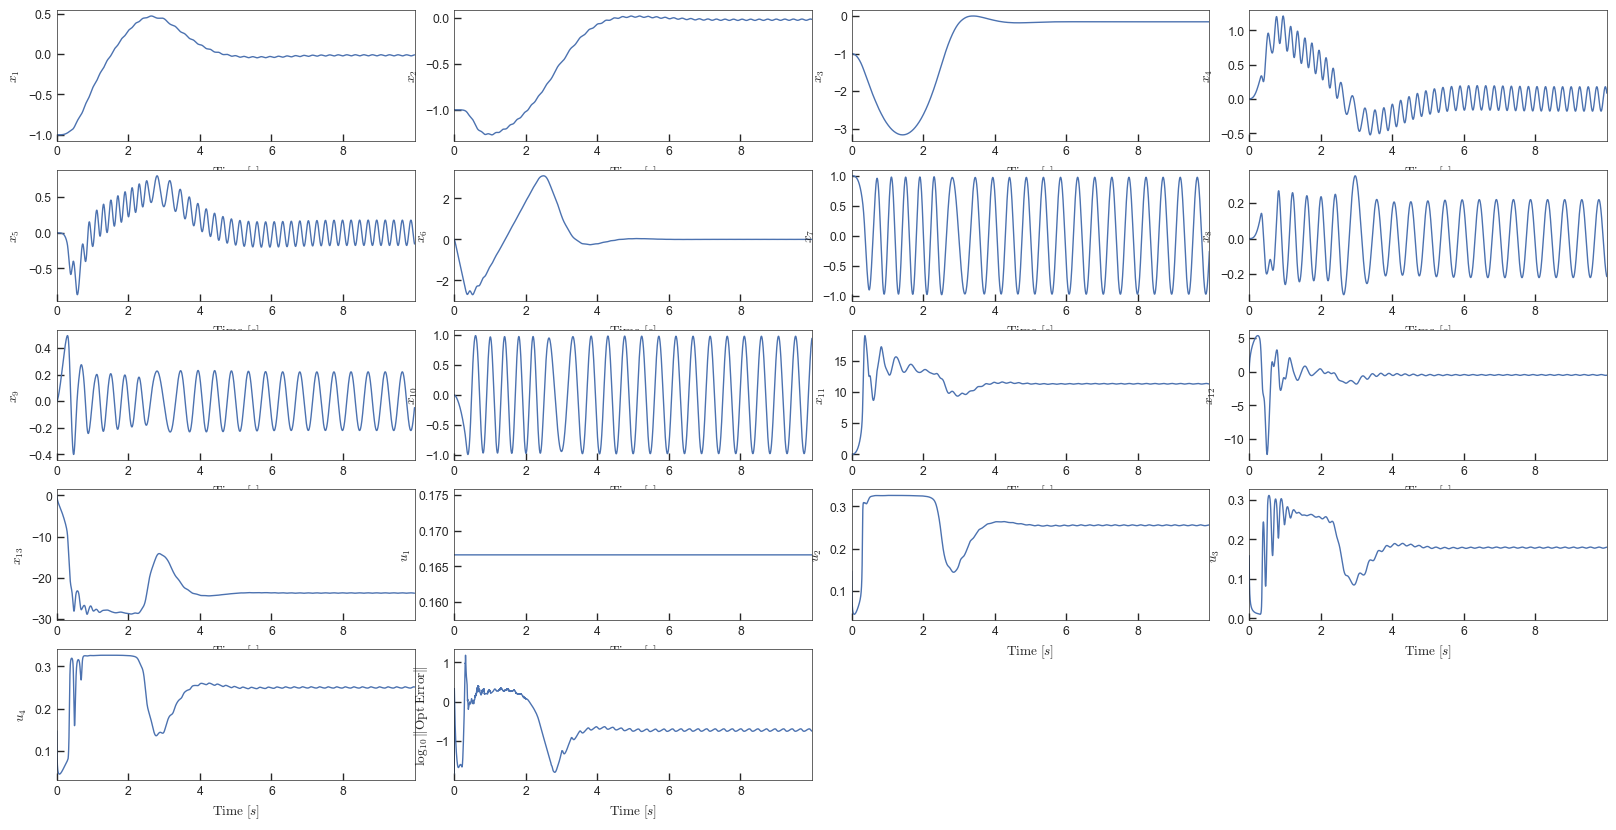

In [19]:
plotter = autogenu.Plotter(log_dir=ag.get_ocp_log_dir(), log_name=ag.get_ocp_name())
plotter.set_scales(2,5,2)
# plotter.show()
plotter.save()

# Run the following 4.1 and 4.2 only when you want to build and install Python interface as it takes long. 


## Build Python interface

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.  
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

## Install Python interface

- `install_prefix` : Prefix of the install destination of the python interfaces. Default is None.
    -  If this is None (default), then it is `~/.local/lib/python3.x` (`python3.x` is your Python version). 
        - If you use Ubuntu, `~/.local/lib/python3.x` is the default Python path, and you do not need to set `PYTHONPATH` additonally.  
        - If you use MacOSX or Windows, add it to the Python PATH, as `export PYTHONPATH=$PYTHONPATH:$HOME/.local/lib/python3.x/site-packages`
    -  If `install_prefix=os.getcwd()`, the python interfaces will be installed to the `cgmres` directory under the current working directory

The usage of Python interfaces is introduced in `examples/python` directory.

## Generate Documentation
The documentations for the generated code are available.  
`Doxygen` is required for the docs generation.